In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from qdrant_client import QdrantClient
from typing import List
from tqdm import tqdm

tqdm.pandas()
sns.set_theme()

In [26]:
# Scoring function from score_cv.py
def get_score(input_resume: str, job_description: str, verbose: bool = False) -> float:
    documents: List[str] = [input_resume]
    client = QdrantClient(path="./local_model")
    client.set_model("BAAI/bge-base-en")

    if client.get_collections().collections:
        client.delete_collection(collection_name="demo_collection")

    client.add(
        collection_name="demo_collection",
        documents=documents,
    )

    search_result = client.query(
        collection_name="demo_collection", query_text=job_description
    )
    similarity_score = round(search_result[0].score * 100, 3)
    return similarity_score

In [27]:
# Load job description
job_desc_path = '/Users/iuliacostea/Desktop/FACTprojectGroup26/sample_input_data/example_job_descriptions/PM_job_descriptions/doordash_pm.txt'  # Adjust path as needed
with open(job_desc_path, 'r') as f:
    job_description = f.read()

print(f"Loaded job description ({len(job_description)} characters)")

Loaded job description (6521 characters)


In [28]:
# Define paths
base_path = '/Users/iuliacostea/Desktop/FACTprojectGroup26/Table1_Experimental_Modified_Resumes'
output_base = os.path.join(base_path, 'output/input_cvs_Table1_Experimental_Modified_Resumes/Original_CV_first_260')

# Model mapping
model_paths = {
    'anthropic_claude-sonnet-4-20250514': 'Claude-Sonnet-4',
    'deepseek_deepseek-chat': 'DeepSeek-Chat',
    'openai_gpt-3.5-turbo': 'GPT-3.5-Turbo',
    'together_meta-llama/Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'together_mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral-8x7B'
}

In [29]:
# Load original CV scores from existing file (no need to re-score)
original_scores_path = os.path.join(base_path, 'Reproducibility_Scores/ScoresDoorDash_PM_Original_File_Original_CV_first_260.csv')
original_scores_df = pd.read_csv(original_scores_path)

print(f"Loaded {len(original_scores_df)} original CV scores")

# Create scores dataframe
scores_df = pd.DataFrame()
scores_df['No Manipulation'] = original_scores_df.iloc[:, 1].values  # Column 1 contains the scores

print(f"✓ Original CVs loaded. Mean score: {scores_df['No Manipulation'].mean():.2f}")

Loaded 260 original CV scores
✓ Original CVs loaded. Mean score: 79.25


In [30]:
# Load each model's modified resume scores from Reproducibility_Scores
score_files = {
    'Claude-Sonnet-4': 'ScoresDoorDash_PM_Original_File_file_2026-01-14_20-31.csv',
    'DeepSeek-Chat': 'ScoresDoorDash_PM_Original_File_file_2026-01-13_12-50.csv',
    'GPT-3.5-Turbo': 'ScoresDoorDash_PM_Original_File_file_2026-01-11_22-48.csv',
    'Llama-3.3-70B': 'ScoresDoorDash_PM_Original_File_file_2026-01-14_21-18.csv',
    'Mixtral-8x7B': 'ScoresDoorDash_PM_Original_File_file_2026-01-13_12-45.csv'
}

scores_path = os.path.join(base_path, 'Reproducibility_Scores')

for model_name, filename in score_files.items():
    file_path = os.path.join(scores_path, filename)
    
    if os.path.exists(file_path):
        print(f"Loading {model_name} from {filename}")
        model_df = pd.read_csv(file_path)
        scores_df[model_name] = model_df.iloc[:, 1].values[:len(scores_df)]  # Column 1 contains scores
        print(f"✓ {model_name} loaded. Mean score: {scores_df[model_name].mean():.2f}")
    else:
        print(f"⨯ File not found: {filename}")

print(f"\n{'='*60}")
print("All model scores loaded!")
print(f"{'='*60}")

Loading Claude-Sonnet-4 from ScoresDoorDash_PM_Original_File_file_2026-01-14_20-31.csv
✓ Claude-Sonnet-4 loaded. Mean score: 79.52
Loading DeepSeek-Chat from ScoresDoorDash_PM_Original_File_file_2026-01-13_12-50.csv
✓ DeepSeek-Chat loaded. Mean score: 79.77
Loading GPT-3.5-Turbo from ScoresDoorDash_PM_Original_File_file_2026-01-11_22-48.csv
✓ GPT-3.5-Turbo loaded. Mean score: 78.82
Loading Llama-3.3-70B from ScoresDoorDash_PM_Original_File_file_2026-01-14_21-18.csv
✓ Llama-3.3-70B loaded. Mean score: 79.83
Loading Mixtral-8x7B from ScoresDoorDash_PM_Original_File_file_2026-01-13_12-45.csv
✓ Mixtral-8x7B loaded. Mean score: 79.20

All model scores loaded!


In [31]:
# Create True Label (adjust threshold as needed - assuming first 130 are unqualified)
scores_df['True Label'] = (scores_df.index >= 130).astype(int)

# Define models list for plotting
models_list = ['No Manipulation', 'Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B']

print("Scores DataFrame shape:", scores_df.shape)
print("Columns:", scores_df.columns.tolist())
print("\nSummary statistics:")
print(scores_df[models_list].describe())

Scores DataFrame shape: (260, 7)
Columns: ['No Manipulation', 'Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B', 'True Label']

Summary statistics:
       No Manipulation  Claude-Sonnet-4  DeepSeek-Chat  GPT-3.5-Turbo  \
count       260.000000       260.000000     260.000000     260.000000   
mean         79.254892        79.517696      79.766788      78.815915   
std           1.830030         1.699971       1.861884       1.992539   
min          73.741000        74.817000      74.380000      73.639000   
25%          77.996500        78.476000      78.554250      77.468750   
50%          79.212500        79.485000      79.751500      78.788500   
75%          80.458500        80.456000      80.904500      80.098500   
max          85.276000        85.019000      84.952000      84.195000   

       Llama-3.3-70B  Mixtral-8x7B  
count     260.000000    260.000000  
mean       79.829381     79.202823  
std         1.650485      2.228161  
min        


Plot saved to img/doordash_pm_new_resumes.pdf and .png


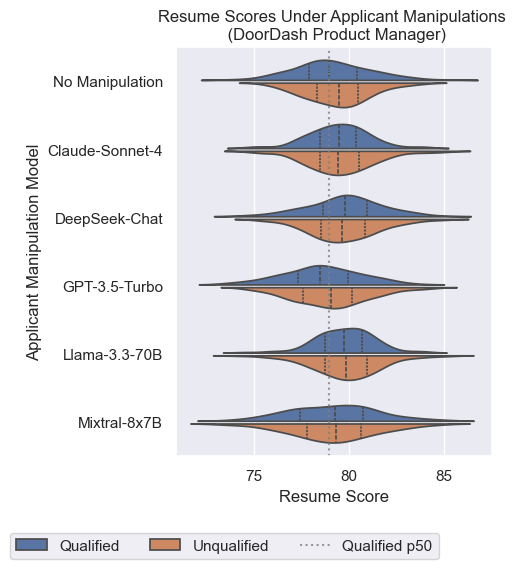

In [32]:
# Create the violin plot
fig, ax = plt.subplots(figsize=(6, 6))

melted_df = pd.melt(scores_df, 
                    id_vars=['True Label'],
                    value_vars=models_list,
                    var_name='LLM',
                    value_name='Resume Score')

melted_df['Ground Truth'] = melted_df['True Label'].map({0:'Unqualified', 1:'Qualified'})
qualified_mean = scores_df[scores_df['True Label'] == 1]['No Manipulation'].median()

sns.violinplot(data=melted_df, x='Resume Score', y='LLM', 
               hue='Ground Truth', split='true', 
               hue_order=['Qualified', 'Unqualified'], 
               inner='quart', gap=0.1)

plt.axvline(x=qualified_mean, color='gray', linestyle=':', alpha=0.8, label='Qualified p50')
plt.ylabel('Applicant Manipulation Model')
plt.title(f"Resume Scores Under Applicant Manipulations \n (DoorDash Product Manager)")
plt.legend(bbox_to_anchor=(-0.55, -0.27), loc='lower left', ncol=3)
plt.tight_layout()

# Save plot
os.makedirs('img', exist_ok=True)
plt.savefig("img/doordash_pm_new_resumes.pdf")
plt.savefig("img/doordash_pm_new_resumes.png", dpi=300)
print("\nPlot saved to img/doordash_pm_new_resumes.pdf and .png")
plt.show()

In [33]:
# Save combined scores
output_scores_path = os.path.join(base_path, 'Combined_Scores_DoorDash_PM_first_260.csv')
scores_df.to_csv(output_scores_path, index=False)
print(f"Combined scores saved to {output_scores_path}")

Combined scores saved to /Users/iuliacostea/Desktop/FACTprojectGroup26/Table1_Experimental_Modified_Resumes/Combined_Scores_DoorDash_PM_first_260.csv


### Statistical Significance Tests

In [34]:
from scipy import stats

# Perform paired t-tests comparing each model to "No Manipulation"
print("="*60)
print("PAIRED T-TESTS: Modified vs No Manipulation")
print("="*60)

model_names = ['Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B']

for model_name in model_names:
    t_stat, p_value = stats.ttest_rel(scores_df[model_name], scores_df['No Manipulation'])
    mean_diff = scores_df[model_name].mean() - scores_df['No Manipulation'].mean()
    
    print(f"\n{model_name}:")
    print(f"  Mean difference: {mean_diff:.3f}")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

PAIRED T-TESTS: Modified vs No Manipulation

Claude-Sonnet-4:
  Mean difference: 0.263
  t-statistic: 1.667
  p-value: 0.096684
  Significant at α=0.05: No

DeepSeek-Chat:
  Mean difference: 0.512
  t-statistic: 5.421
  p-value: 0.000000
  Significant at α=0.05: Yes

GPT-3.5-Turbo:
  Mean difference: -0.439
  t-statistic: -5.126
  p-value: 0.000001
  Significant at α=0.05: Yes

Llama-3.3-70B:
  Mean difference: 0.574
  t-statistic: 3.681
  p-value: 0.000282
  Significant at α=0.05: Yes

Mixtral-8x7B:
  Mean difference: -0.052
  t-statistic: -0.471
  p-value: 0.638040
  Significant at α=0.05: No


In [35]:
# Separate qualified and unqualified groups for each model
print("\n" + "="*60)
print("ANALYSIS BY QUALIFICATION STATUS")
print("="*60)

qualified = scores_df[scores_df['True Label'] == 1]
unqualified = scores_df[scores_df['True Label'] == 0]

print(f"\nQualified candidates (n={len(qualified)}):")
print(f"Unqualified candidates (n={len(unqualified)}):")

print("\n" + "-"*60)
print("Mean Scores by Group:")
print("-"*60)

for model_name in models_list:
    qual_mean = qualified[model_name].mean()
    unqual_mean = unqualified[model_name].mean()
    diff = qual_mean - unqual_mean
    
    print(f"\n{model_name}:")
    print(f"  Qualified:   {qual_mean:.3f}")
    print(f"  Unqualified: {unqual_mean:.3f}")
    print(f"  Difference:  {diff:.3f}")


ANALYSIS BY QUALIFICATION STATUS

Qualified candidates (n=130):
Unqualified candidates (n=130):

------------------------------------------------------------
Mean Scores by Group:
------------------------------------------------------------

No Manipulation:
  Qualified:   79.106
  Unqualified: 79.404
  Difference:  -0.298

Claude-Sonnet-4:
  Qualified:   79.463
  Unqualified: 79.573
  Difference:  -0.110

DeepSeek-Chat:
  Qualified:   79.791
  Unqualified: 79.742
  Difference:  0.049

GPT-3.5-Turbo:
  Qualified:   78.560
  Unqualified: 79.071
  Difference:  -0.511

Llama-3.3-70B:
  Qualified:   79.795
  Unqualified: 79.864
  Difference:  -0.069

Mixtral-8x7B:
  Qualified:   79.186
  Unqualified: 79.220
  Difference:  -0.034


In [36]:
# Test if manipulation reduces the gap between qualified and unqualified
print("\n" + "="*60)
print("EFFECT OF MANIPULATION ON QUALIFICATION GAP")
print("="*60)

baseline_gap = qualified['No Manipulation'].mean() - unqualified['No Manipulation'].mean()
print(f"\nBaseline gap (Qualified - Unqualified): {baseline_gap:.3f}")

print("\n" + "-"*60)
print("Gap after manipulation:")
print("-"*60)

model_names = ['Claude-Sonnet-4', 'DeepSeek-Chat', 'GPT-3.5-Turbo', 'Llama-3.3-70B', 'Mixtral-8x7B']

for model_name in model_names:
    model_gap = qualified[model_name].mean() - unqualified[model_name].mean()
    gap_reduction = baseline_gap - model_gap
    reduction_pct = (gap_reduction / baseline_gap) * 100
    
    print(f"\n{model_name}:")
    print(f"  Gap: {model_gap:.3f}")
    print(f"  Gap reduction: {gap_reduction:.3f} ({reduction_pct:.1f}%)")


EFFECT OF MANIPULATION ON QUALIFICATION GAP

Baseline gap (Qualified - Unqualified): -0.298

------------------------------------------------------------
Gap after manipulation:
------------------------------------------------------------

Claude-Sonnet-4:
  Gap: -0.110
  Gap reduction: -0.188 (63.2%)

DeepSeek-Chat:
  Gap: 0.049
  Gap reduction: -0.347 (116.4%)

GPT-3.5-Turbo:
  Gap: -0.511
  Gap reduction: 0.213 (-71.3%)

Llama-3.3-70B:
  Gap: -0.069
  Gap reduction: -0.230 (77.0%)

Mixtral-8x7B:
  Gap: -0.034
  Gap reduction: -0.264 (88.6%)
